#### Ομάδα 70:
**Χρήστος Παπαδημητρίου, el18017**

**Ζαχαρίας Αναστασιάδης, el18161**

**Βαρθολομαίος Βαμβακάρης, el18071**

Έχουμε προσθέσει κάποια sections στο notebook, των οποίων οι επικεφαλίδες έχουν την σημείωση _`(Τροποποίηση)`_. Επίσης, στο τέλος του notebook έχουμε συγκεντρώσει τα σχόλια μας.

##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Παράμετροι για πειραματισμό

Εδώ είναι συγκεντρωμένες κάποιες παράμετροι με των οποίων τις τιμές πειραματιστήκαμε, αφού ολοκληρώσαμε τις βασικές βελτιστοποιήσεις στο notebook.

In [ ]:
# originally: 
# caption_lower_size = 0
# caption_upper_size = inf
# vocabulary_size = 5000
# dropout_rate = 0.5
# num_layers = 2
# num_heads = 2
# learning_rate = 1e-4
# units = 264

# caption lengths allowed in the training captions
caption_lower_size = 4
caption_upper_size = 24

vocabulary_size = 10000
dropout_rate = 0.22
num_layers = 8
num_heads = 2
learning_rate = 0.8*1e-4
units = 400

# parameter for beam search
N_beam = 2

# max generated caption length 
max_len = 30

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 5s (81.0 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.6 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.2 MB/s eta 0:00:00


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Εισαγωγή του Dataset `flickr30k-images-ecemod` (Τροποποίηση)

In [ ]:
# Download image files

image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',

                                      cache_subdir=os.path.abspath('.'),

                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',

                                      extract=True)

os.remove(image_zip)

4376381805/4376381805 [==============================] - 370s 0us/step


In [ ]:
# Download captions file

captions_file = tf.keras.utils.get_file('captions_new.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',

                                           extract=False)


# Download train files list

train_files_list = tf.keras.utils.get_file('train_files.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',

                                           extract=False)


# Download test files list

test_files_list = tf.keras.utils.get_file('test_files.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',

                                           extract=False)

66196/66196 [==============================] - 0s 2us/step


In [ ]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)

   

captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

   

cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)

   

train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]

   

test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

   

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_captions[0]

('image_dir/_3430497.jpg',
 ['The skier is wearing a yellow jumpsuit and sliding across a yellow rail .',
  'A yellow uniformed skier is performing a trick across a railed object .',
  'A skier in electric green on the edge of a ramp made of metal bars .',
  'A person on skis on a rail at night .',
  'A skier slides along a metal rail .'])

<a name="large_and_small_captions"></a>

### Αφαίρεση Πολύ Μεγάλων και Πολύ Μικρών Captions (Τροποποίηση)

Κάνουμε ένα ιστόγραμμα με τα μεγέθη των captions στο train-set:

100%|██████████| 21000/21000 [00:00<00:00, 189904.54it/s]


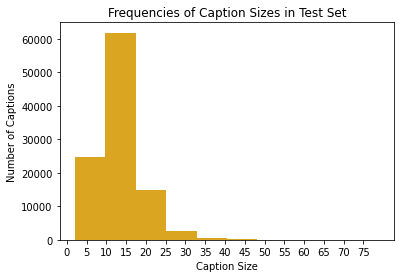

In [ ]:
import matplotlib.pyplot as plt
import tqdm 

lengths_list = []

for (path, capts) in tqdm.tqdm(train_captions):
  for capt in capts:
    lengths_list.append(len(capt.split(' ')))
plt.title("Frequencies of Caption Sizes in Test Set")
plt.xlabel("Caption Size")
plt.ylabel("Number of Captions")
plt.xticks([i/10 for i in range(0,800,50)])
plt.hist(lengths_list, color='goldenrod')

del lengths_list

Παρατηρούμε ότι οι πλειοψηφία των captions του training set έχουν γύρω στις 10-15 λέξεις. Με βάση αυτήν την παρατήρηση επιχειρήσαμε να αφαιρέσουμε captions που ξεφεύγουν πολύ από αυτήν την περιοχή, δοκιμάζοντας διάφορες τιμές για τις παραμέτρους `caption_lower_size` και `caption_upper_size` της παρακάτω συνάρτησης.

In [ ]:
def remove_caption_outliers(initial_captions):
  counter1 = 1
  train_captions_filtered = []

  for (path, capts) in initial_captions:
    flag = True

    for capt in capts:
      if len(capt.split(' ')) < caption_lower_size or len(capt.split(' ')) > caption_upper_size:
        counter1+=1
        flag = False
        break

    if flag:
      train_captions_filtered.append((path, capts))
  print(f"Removed {counter1} captions.")
  del counter1
  return train_captions_filtered

In [ ]:
train_captions_filtered = remove_caption_outliers(train_captions)
train_raw = tf.data.experimental.from_list(train_captions_filtered)

Removed 3685 captions.


### Google Drive Mount (Τροποποίηση)

Παρακάτω είναι ο κώδικας για το Google Drive Mount, το οποίο τελικά αποφασίσαμε να μην χρησιμοποιήσουμε, γιατί κρίναμε ότι προκαλούσε μεγάλες καθυστερήσεις όταν γίνονταν load οι εικόνες από το Drive στα επόμενα βήματα.

In [ ]:
# # load data from drive 
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/content'
# path = pathlib.Path(path)
# IMAGE_DIR="image_dir"

# # train_captions = [(str(new_path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
# # test_captions = [(str(new_path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
  

# captions = (path/captions_file).read_text().splitlines()

# captions = (line.split('\t') for line in captions)

# captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

   

# cap_dict = collections.defaultdict(list)

# for fname, cap in captions:

#   cap_dict[fname].append(cap)

   

# train_files = (path/train_files_list).read_text().splitlines()

# train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]

   

# test_files = (path/test_files_list).read_text().splitlines()

# test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

   

# train_raw = tf.data.experimental.from_list(train_captions)

# test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


In [ ]:
# for _, capts in train_raw.take(50):
#   print(capts)

### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [ ]:
IMAGE_SHAPE=(224, 224, 3)

In [ ]:
# mobilenet = tf.keras.applications.MobileNetV3Small(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)
# mobilenet.trainable=False

# mobilenet = tf.keras.applications.EfficientNetB2(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     weights='imagenet'
#     )
# mobilenet.trainable=False

# mobilenet = tf.keras.applications.EfficientNetB5(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     weights='imagenet')
# mobilenet.trainable=False

mobilenet = tf.keras.applications.ConvNeXtLarge(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
mobilenet.trainable=False

785596384/785596384 [==============================] - 5s 0us/step


Here's a function to load an image and resize it for the model:

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 1536)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.regex_replace(s, '[0-9!@#$%^&*()_+-=[\];\':"\\|,.<>/?]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s
 

In [ ]:
# Use the top 10000 words for a vocabulary.
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'is']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 753, 5, 2, 69, 4], [3, 2, 2470, 25, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
# save_dataset(train_raw, '/content/drive/MyDrive/train_cache', mobilenet, tokenizer)
# save_dataset(test_raw, '/content/drive/MyDrive/test_cache', mobilenet, tokenizer)

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
# train_ds = load_dataset('/content/drive/MyDrive/train_cache')
# test_ds = load_dataset('/content/drive/MyDrive/test_cache')

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 20)
(32, 20)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2   58 1941   25  170   57  278   84    0    0    0    0    0
    0    0    0    0    0    0]
[   2   58 1941   25  170   57  278   84    4    0    0    0    0    0
    0    0    0    0    0    0]


<a name='pretrained_embeddings'></a>

## Εισαγωγή Pretrained Embeddings από το Gensim (Τροποποίηση)

In [ ]:
%pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Κατεβάζουμε τα embeddings:

In [ ]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2023-02-25 13:24:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-25 13:24:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-25 13:24:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


Κάνουμε extract:

In [ ]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

Φτιάχνουμε dictionary με τα embeddings:

In [ ]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


vocabulary με word indices, από τον vectorizer:

In [ ]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

Κατασκευή Embedding Matrix:

In [ ]:
num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9503 words (497 misses)


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

Κατασκευάζουμε το (Pretrained) Embedding Layer:

In [ ]:
# embedding_matrix

In [ ]:
# class SeqEmbedding(tf.keras.layers.Layer):
#   def __init__(self, vocab_size, max_length, depth):
#     super().__init__()
#     self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

#     self.token_embedding = tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=depth,
#         mask_zero=True)
    
#     self.add = tf.keras.layers.Add()

#   def call(self, seq):
#     seq = self.token_embedding(seq) # (batch, seq, depth)

#     x = tf.range(tf.shape(seq)[1])  # (seq)
#     x = x[tf.newaxis, :]  # (1, seq)
#     x = self.pos_embedding(x)  # (1, seq, depth)

#     return self.add([seq,x])

<a name='seq_embedding'></a>

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding  = tf.keras.layers.Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )

    # dense layer to match depth and dimension_dim sizes
    # self.frozen_layer = tf.keras.layers.Dense(depth, trainable=False, 
    #                                           kernel_initializer=tf.keras.initializers.Ones())
    self.frozen_layer = tf.keras.layers.Dense(depth, kernel_initializer=tf.keras.initializers.Ones())
        
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)
    seq = self.frozen_layer(seq)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    
    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.

# commenting the following one out cause it takes too long to run
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

2706it [02:30, 17.94it/s]


Uniform entropy: 9.21
Marginal entropy: 5.55


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun
  # changing max_length to 30
  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=30, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=units, dropout_rate=dropout_rate, num_layers=num_layers, num_heads=num_heads)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 4us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a
a a on a
sign costume against trampoline a street back to open the wearing upside rodeo the wooden orange intersection each past a of a two children is stream looking day colorful


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

### Beam Search Generator (Τροποποίηση)

In [ ]:
@Captioner.add_method
def beam_gen(self, image, N=2):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  # tokens = initial # (batch, sequence)
  sequences = [[initial, 0.0]]
  for n in range(50):
    all_candidates = list()
    for tokens, score in sequences:
      if tokens[0][-1] == 4:
        continue
      preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  #(batch, vocab)
      
      best = tuple(tf.math.top_k(preds, k=N))
      # print(best)
      for i in range(N):
        score2 = best[0][0].numpy()[i]
        token2 = best[1][0].numpy()[i]
        new_t = tf.concat([tokens, np.array([token2]).reshape((1,1))], axis=1)
        candidate = [new_t, score - score2]
        all_candidates.append(candidate)
      
      # for j in range(5000):
      #   new_t = tf.concat([tokens, np.array([j]).reshape((1,1))], axis=1)
      #   candidate = [new_t, score - preds[0][j]]
      #   #print(candidate)
      #   all_candidates.append(candidate)

    #print(tf.argmax(preds, axis=-1)[:, tf.newaxis])
    ordered = sorted(all_candidates, key=lambda tup: tup[1])

    #print(max(all_candidates, key=lambda tup: tup[1]))
    #print(ordered)
    #sequences = ordered[:N]

    while len(sequences) < N:
      sequences.append([initial, 0.0])

    remaining = N
    for i, [tokens, score] in enumerate(sequences):
      if tokens[0][-1] == 4 or remaining <= 0:
        continue
      
      sequences[i] = ordered[N-remaining]
      remaining -= 1

    
    # print(sequences)




    # if next[0] == self.word_to_index('[END]'):
    #   break
  tokens = min(sequences, key=lambda seq: seq[1])[0]
  #tokens = sequences[-1][0]
  
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    # for t in (0.0, 0.5, 1.0):
    result = self.model.beam_gen(self.image, N=N_beam)
    print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2856 - masked_acc: 0.1710

a man man man in a

100/100 [==============================] - 210s 1s/step - loss: 5.2856 - masked_acc: 0.1710 - val_loss: 5.1863 - val_masked_acc: 0.1787
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 5.0402 - masked_acc: 0.1996

a man in a in a

100/100 [==============================] - 156s 2s/step - loss: 5.0402 - masked_acc: 0.1996 - val_loss: 5.0189 - val_masked_acc: 0.1975
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.8609 - masked_acc: 0.2343

a man in a man

100/100 [==============================] - 139s 1s/step - loss: 4.8609 - masked_acc: 0.2343 - val_loss: 4.7898 - val_masked_acc: 0.2322
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 4.6304 - masked_acc: 0.2608

a man in a man in a man in a

100/100 [==============================] - 161s 2s/step - loss: 4.6304 - masked_acc: 0.2608 - val_loss: 4.553

Plot the loss and accuracy over the training run:

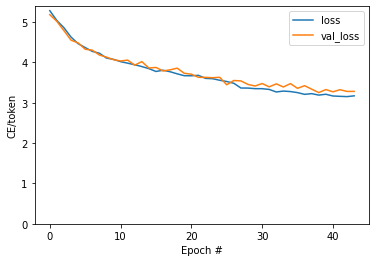

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

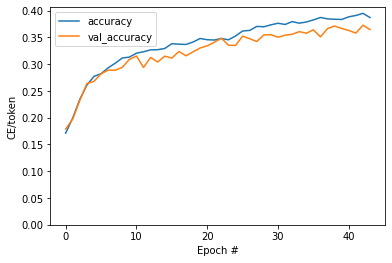

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'a man is riding a wave'

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49]),
 TensorShape([1, 2, 7, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        ], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

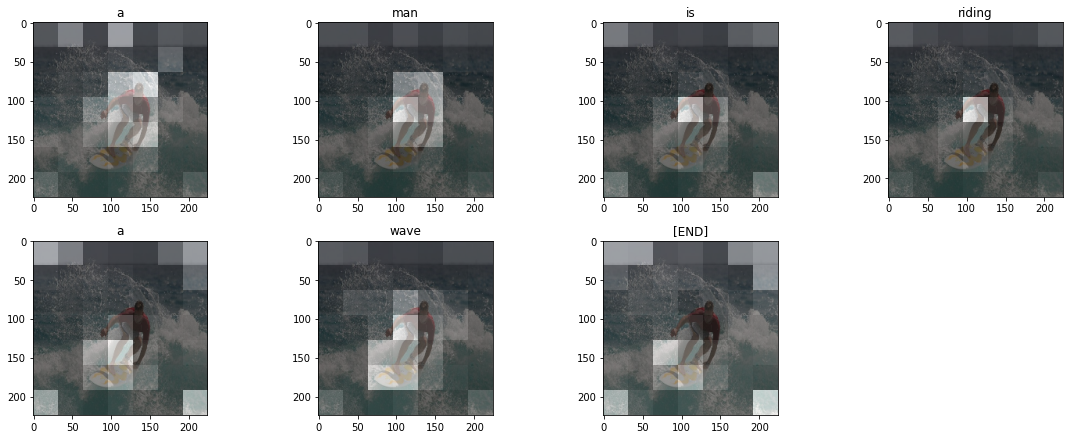

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


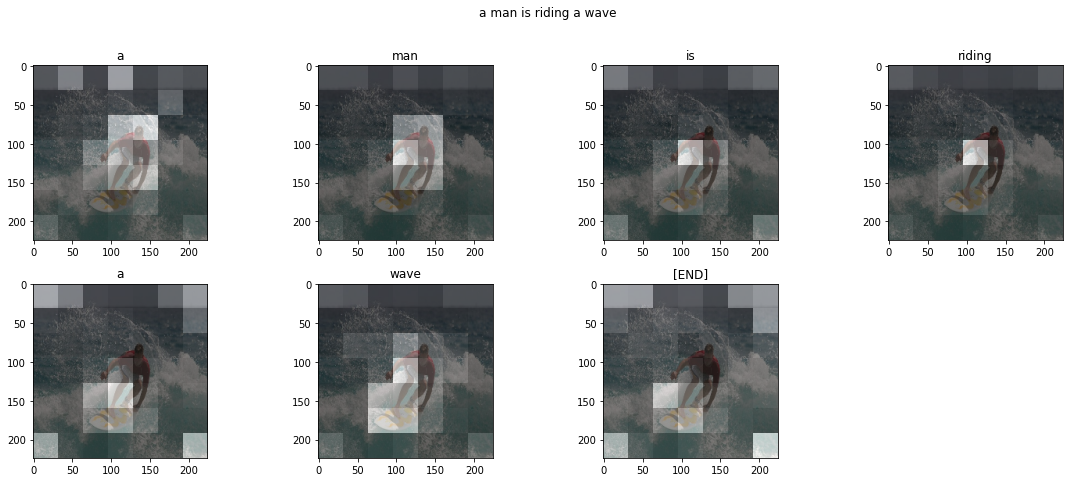

In [ ]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


67460/67460 [==============================] - 0s 6us/step


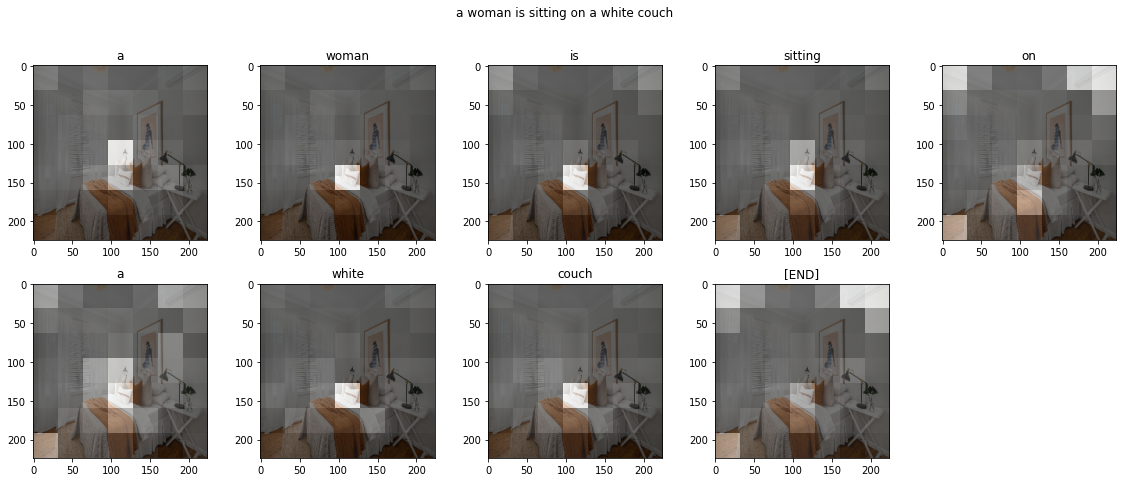

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

## Παραγωγή Captions για τον Διαγωνισμό

Παρακάτω παράγουμε τα captions για τις εικόνες του διαγωνισμού στο Codalab.

In [ ]:
# for competition

path="."

IMAGE_DIR="image_dir"

path = pathlib.Path(path)
competition_files_list = tf.keras.utils.get_file('competition_files.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/competition_files.csv',

                                           extract=False)

competition_files = (path/competition_files_list).read_text().splitlines()

# test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
competition_paths = [str(path/IMAGE_DIR/fname) for fname in competition_files]

7399/7399 [==============================] - 0s 0us/step


In [ ]:
hypothesises_strings = [model.beam_gen(load_image(path), N=N_beam) for path in competition_paths]
hypothesises_strings = list(map(lambda item : (item[:len(item)-1]) if item.endswith('.') else item, hypothesises_strings))
test_hypotheses = [item.split(' ') for item in hypothesises_strings]

In [ ]:
import json 
import random

r = random.randint(100,1000)
filename = f"test_hypotheses_{r}.json"

jsonString = json.dumps(test_hypotheses)
jsonFile = open(filename, "w")
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
from google.colab import files

files.download(f"/content/{filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Παραγωγή Captions για 1000 εικόνες του Test Set

Παρακάτω παράγουμε captions για τις πρώτες 1000 εικόνες του test set. Στη συνέχεια κατεβάζουμε τα Captions σαν json αρχέιο. Επιλέξαμε αυτή την στρατηγική για μπορέσουμε να παρουσιάσουμε τα αποτελέσματά μας. Συγκεκριμένα προσπαθήσαμε να αποθηκεύουμε έιτε όλο το μοντέλο έιτε τις τιμές των βαρών, αλλά αυτό κατέστει αδύνατο, καθώς ήταν τόσο χρονοβόρο, ώστε το notebook έκανε πάντα timeout πάνω στην διαδικασία και χανόταν όλη μας η πρόοδος.

In [ ]:
# generate the captions
captions1000 = test_captions[:1000]
hypotheses_strings_list = [model.beam_gen(load_image(path), N=N_beam) for (path, refs) in captions1000]
hypotheses_strings_list = list(map(lambda item : (item[:len(item)-1]) if item.endswith('.') else item, hypotheses_strings_list))
hypotheses_list = [item.split(' ') for item in hypotheses_strings_list]

In [ ]:
# convert them to json and download the file
import json 
from google.colab import files

filename = f"captions1000_pretrained.json"

jsonString = json.dumps(hypotheses_list)
jsonFile = open(filename, "w")
jsonFile.write(jsonString)
jsonFile.close()

files.download(f"/content/{filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aξιολόγηση της ποιόητας του captioning (BLEU)

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk.translate.bleu_score as bl
wweights=(0.4, 0.3, 0.2, 0.1)
ssmoothing_function = bl.SmoothingFunction().method1

In [ ]:
def format_ref(refList):
  refList = list(map(lambda item : (item[:(len(item)-1)] if item.endswith('.') else item), refList))
  refs =  [item.split(' ') for item in refList]
  return list(map(lambda l : l[:len(l)-1] if l[len(l)-1] == '' else l, refs))

In [ ]:
def sentence_bleu(captionTuple, hypothesis=None):
  """
    captionTuple is in the form: (image_path, [reference1, reference2, ...])
  """
  (image_path, references) = captionTuple
  if not hypothesis:
    image = load_image(image_path)
    hypothesis = model.beam_gen(image)
    hypothesis = hypothesis.split(' ')
  references = format_ref(references)
  return bl.sentence_bleu(references, hypothesis, weights=wweights, smoothing_function=ssmoothing_function) 

In [ ]:
def corpus_bleu(captionTuples, hypotheses=None):
  """
    captionTuples is a list of tuples of the following form: (image_path, [reference1, reference2, ...])
  """
  if not hypotheses:
    # generate captions as strings
    hypotheses_strings_list = [model.beam_gen(load_image(path), N=N_beam) for (path, refs) in captionTuples]
    # turn captions into lists of strings
    hypotheses_list = [item.split(' ') for item in hypotheses_strings_list]
  else:
    hypotheses_list = hypotheses
  
  # extract captions from (path, captions) tuples
  references_strings_list =  list(map(lambda captionTuple : captionTuple[1], captionTuples))
  # remove '.' from the ends of captions and split them into lists of strings (this is done by get_ref())
  references_list = list(map(format_ref, references_strings_list))
  return bl.corpus_bleu(references_list, hypotheses_list, weights=wweights, smoothing_function=ssmoothing_function)

## Πειραματισμός με Encoders

Δοκιμάσαμε τους : MobileNetV3Small, EfficientNetB2 και EfficientNetB5 και τους αξιλογήσαμε με βάση το corpus_bleu σε ένα ενδεικτικό σύνολο από 200 captions. Επιλέξαμε να εργαστούμε με τον EfficientNetB5. Συγκεκριμένα, αν και είναι αρκετά πιο αργός στο inference, φαίνεται να έχει σημαντικά καλύτερη επίδοση σε σχέση με τους άλλους Encoders. Στην συνέχεια τον πειραμάτων μας, λοιπόν χρησιμοποιήσαμε αυτόν.


|Encoder|Time(ms) per inference step|Bleu Score for 200 captions|
|:-:|:-:|:-:|
|MobileNetV3Small|3.4|0.055|
|EfficientNetB2|6.5|0.053|
|EfficientNetB5|25.3|0.077|

## Embeddings

Δοκιμάσαμε να χρησιμοποιήσουμε τα pretrained embeddings glove-wiki του Gensim.  Τα εισάγουμε σε [αυτό](#pretrained_embeddings) το section του notebook, ενώ βασιστήκαμε σε [αυτό](https://keras.io/examples/nlp/pretrained_word_embeddings/) το tutorial για την κατανόηση του τρόπου χρήσης τους. Τα καλύτερα μεταξύ αυτών αποδέιχθηκαν τα 300-d. Οι δοκιμές μας δεν έδωσαν σαφείς ενδείξεις για το αν τα learned ή τα pretrained embeddings είναι καλύτερα για την περίπτωσή μας, συνεπώς στην συνέχεια κάναμε δοκιμές και με τις δύο αυτές επιλογές. Eνδεικτικά, τα καλύτερα corpus_bleu που πετύχαμε για ένα σύνολο από 200 captions με pretrained και learned embeddings αντίστοιχα, σε αυτή τη φάση των δοκιμών:

|Embeddings|Bleu Score for 200 captions|
|:-:|:-:|
|Learned |0.095|
|Pretrained|0.090|



Σημειώνουμε επίσης ότι τροποποιήσαμε την κλάση `SeqEmbedding()` για να υποστηρίζει τα pretrained embeddings, Ο τροποποιημένος (υπάρχει σε [αυτό](#seq_embedding) το σημείο) είναι ο ακόλουθος:

```py
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding  = tf.keras.layers.Embedding(
        input_dim=num_tokens,
        output_dim=embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )

    # dense layer to match depth and dimension_dim sizes
    # self.frozen_layer = tf.keras.layers.Dense(depth, trainable=False, 
    #                                           kernel_initializer=tf.keras.initializers.Ones())
    self.frozen_layer = tf.keras.layers.Dense(depth, kernel_initializer=tf.keras.initializers.Ones())
        
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)
    seq = self.frozen_layer(seq)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    
    return self.add([seq,x])
```

## Προεπεξεργασία Κειμένου


### Standardize

Σχετικά με την συνάρτηση `standardize` δεν μπορέσαμε να εντοπίσουμε πολλές τροποποιήσεις που θα μπορούσαν να βοηθήσουν. Το μόνο που επιλέξαμε να προσθέσουμε είναι λειτουργικότητα για την αφαίρεση υποσυμβολοσειρών που περιέχουν νούμερα.

### Μικρά και Μεγάλα Captions

Φτιάξαμε ένα ιστόγραμμα με τα μεγέθη των captions στο training dataset, το οποίο φαίνεται και παρακάτω:

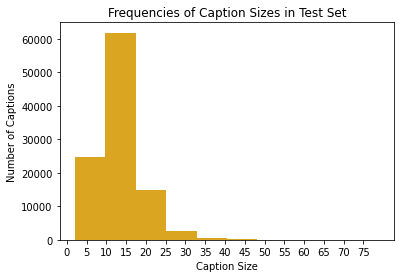

Είναι φανερό ότι η πλειοψηφία των captions κινείται μεταξύ 10-15 λέξεων. Πειραματιστήκαμε με την αφαίρεση captions που δεν φτάνουν κάποιο ελάχιστο μήκος ή ξεπερνούν κάποιο μέγιστο μήκος και έιδαμε θετικά αποτελέσματα. Τα όρια στα οποία καταλήξαμε έιναι:

- `caption_lower_size = 4`
- `caption_upper_size = 24`

Το section όπου κάνουμε αυτές τις τροποποιήσεις είναι [εδώ](#large_and_small_captions).

### Vocabulary Size


Όσον αφορά το vocabulary size, παρατηρήσαμε ότι έχει επίπτωση στην επίδοση (bleu score), αλλά και στον χρόνο εκπαίδευσης, καθώς μεγαλύτερα vocabularies συνδυαζονταν γενικά με μεγαλύτερους χρόνους εκπαίδευσης. Καταλήξαμε ότι όταν χρησιμοποιούσαμε learned embeddings, ήταν καλύτερα μικρότερα vocabularies (4.000-5.000 λέξεις). Αντίθετα δίκτυα με pretrained embeddings ευνοούνταν από μεγαλύτερα vocabularies (~10.000 λέξεις). Αυτό άλλωστε είναι λογικό, αφού τα learned embeddings φτιάχνονται ad hoc για την περίπτωσή μας, ενώ τα pretrained προέρχονται από πιο γενικευμένη εκπαίδευση και συνεπώς συνδυάζονται καλύτερα με ένα μεγαλύτερο (και άρα γενικότερο) λεξιλόγιο.

## Sentence Generator: Beam Search

H χρήση του Beam Search generator ήταν με διαφορά η τροποποίηση με την μεγαλύτερη επίδραση στην ποιότητα των captions. Συγκεκριμένα, καταλήξαμε ότι η χρήση του συγκεκριμένου generator βελτιώνει την επίδοση (corpus bleu) ενός μοντέλου κατά έναν παράγοντα 2-3 (πολλαπλασιαστικά) σε σχέση με τον simple generator, αν κρατήσουμε τις υπόλοιπες παραμέτρους σταθερές. Ενδεικτικά, παραθέτουμε τα scores δύο μοντέλων με pretrained embeddings που διαφέρουν μόνο στον sentence generator:

|Encoder|Caption Size Range|Vocabulary Size|Embeddings Type|Embeddings Dimension|Units|Sentence Generator|Bleu Score for 200 captions|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|EfficientNetB5|5-25|10000|Pretrained|300|300|simple_gen|0.089|
|EfficientNetB5|5-25|10000|Pretrained|300|300|beam_gen|0.209|

## Υπερπαραμετροι του Decoder & Πειράματα

Αφού ολοκληρώσαμε τις βελτιώσεις και τις παρατηρήσεις που περιγράψαμε παραπάνω, προχωρήσαμε σε μιά σειρά δοκιμών, όσον αφορά τις υπερπαραμέτρους του decoder. Όπως έχουμε ήδη αναφέρει, δεν είχαμε σαφείς ενδείξεις για το αν τα pretrained embeddings ή τα learned embeddings αποδίδουν καλύτερα. Συνεπώς, κάναμε ξεχωριστά πειράματα για αυτές τις δύο περιπτώσεις. Σε ό,τι αφορά την διαδικασία που ακολουθήσαμε για τα πειράματα, επιλέξαμε να κάνουμε κάθε φορά ολοκληρωμένο training και να αξιολογούμε τα αποτελέσματά μας σε 200 captions του test set για να παίρνουμε μια ενδεικτική εικόνα τις απόδοσης του δικτύου με τις εκάστοτε παραμέτρους.

### Learned Embeddings

Ακολουθεί ένας πίνακας με κάποια από τα καλύτερα αποτελέσματα που πετύχαμε χρησιμοποιώντας learned embeddings:

<div align='center'>

|Index| Encoder        | #units | num_layers | Learning Rate | Dropout Rate | Βleu Score σε 200 captions
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|1| EfficientNetB5 | 280    | 3          | 0.75\*1e-4    | 0.25      | 0.231        |
|2| **EfficientNetB5** | **280**    | **3**          | **0.8\*1e-4**     | **0.25**      | **0.248**        |
|3| EfficientNetB5 | 290    | 3          | 0.8\*1e-4     | 0.25      | 0.23         |
|4| EfficientNetB5 | 300    | 3          | 0.8\*1e-4     | 0.2       | 0.207        |
|**5**| **EfficientNetB5** | **300**    | **3**          | **0.8\*1e-4**     | **0.25**      | **0.249**        |
|6| EfficientNetB5 | 350    | 3          | 0.8\*1e-4     | 0.25      | 0.226        |
|7| EfficientNetB5 | 350    | 8          | 0.8\*1e-4     | 0.25      | 0.237        |
|8| EfficientNetB5 | 350    | 8          | 0.8\*e-5      | 0.25      | 0.226        |
|9| EfficientNetB5 | 350    | 6          | 1.2\*1e-4     | 0.25      | 0.202        |
|10| EfficientNetB5 | 350    | 8          | 1.2\*1e-4     | 0.25      | 0.215        |
|11| EfficientNetB5 | 400    | 8          | 0.8\*1e-4     | 0.25      | 0.226        |
|12| EfficientNetB5 | 400    | 8          | 0.8\*e-5      | 0.25      | 0.228        |
|13| EfficientNetB5 | 400    | 8          | 1\*e-5        | 0.1       | 0.219        |
|14| EfficientNetB5 | 400    | 8          | 1\*e-5        | 0.2       | 0.234        |
|15| EfficientNetB5 | 400    | 8          | 1\*e-5        | 0.25      | 0.236        |
|16| EfficientNetB5 | 400    | 6          | 1\*e-5        | 0.25      | 0.207        |
|17| EfficientNetB5 | 400    | 8          | 1\*e-5        | 0.25      | 0.195        |
|18| EfficientNetB5 | 400    | 8          | 0.5\*1e-4     | 0.25      | 0.221        |
|19| EfficientNetB5 | 400    | 8          | 1\*e-4        | 0.25      | 0.243        |
|20| EfficientNetB5 | 450    | 8          | 1\*e-5        | 0.25      | 0.208        |
|21| EfficientNetB5 | 512    | 3          | 0.8\*1e-4     | 0.22      | 0.232        |
|22| EfficientNetB5 | 1024   | 3          | 0.8\*1e-4     | 0.25      | 0.232        |

</div>

Σχόλια:

- Παρουσιάζουμε τις παραπάνω κατηγορίες παραμέτρων, γιατί είχαν το περισσότερο ενδιαφέρον. Ασχοληθήκαμε επίσης με το beam search width και τον αριθμό των heads, αλλά αυτά δεν έδωσαν καλά αποτελέσματα. Συνεπώς, τα κρατήσαμε σταθερά, στις default τιμές τους. Σημειώνουμε επίσης ότι χρησιμοποιούσαμε `vocabulary size`=4000, το οποίο είχαμε αναδείξει νωρίτερα ως καλό μέγεθος για learned embeddings,

- Όσον αφορά τον `encoder`, όπως είπαμε και πιο πριν χρησιμοποιήσαμε μόνο τον EfficientNet5

- Για το `learning rate` διερευνήσαμε τιμές στο διάστημα $10^{-5}$ εώς $10^{-3}$. Τα καλύτερα αποτελέσματα πετύχαμε με τιμές γύρω στο $10^{-4}$ (συγκεκριμένα η καλύτερη τιμή είναι $0.8*10^{-4}$). 

- Για το `πλήθος των Νευρώνων (#units)` κινηθήκαμε κυρίως στην περιοχή 280-400. Κάναμε επίσης και δύο ενδεικτικές δοκιμές για μεγαλύτερα πλήθη νευρώνων (512 και 1024).

- Όσον αφορά το `num_layers` δοκιμάσαμε διάφορες τιμές μεταξύ 2-8

- Όσον αφορά την παράμετρο `dropout rate`, δοκιμάσαμε τιμές στο διάστημα 0.1-0.3, αλλά πρακτικά, όλα τα καλά configurations είχαν τιμή 0.25 ή 0.2

- H βασική μας παρατήρηση είναι ότι εδώ έχουν καλύτερη απόδοση μικρότερα και πιο απλά δίκτυα. Ενδεικτικό είναι ότι το καλύτερο score επιτεύχθηκε με 300 νευρώνες και 3 layers, ενώ αυξάνοντας τους νευρώνες ή και τα layers δεν μπορέσαμε να ξεπεράσουμε αυτό το score.

- Δευτερευόντος, για το learning rate παρατηρήσαμε ότι η καλύτερη τιμή είναι το 0.8*1e-4

- Τα δύο καλύτερα αποτελέσματα (`index=2` και `index=5`) είναι σημειωμένα με bold στον πίνακα. Την καλύτερη επίδοση πετύχαμε με το configuration με `index=5`, το οποίο επαναλαμβάνουμε και εδώ:

<div align='center'>

|Index| Encoder        | #units | num_layers | Learning Rate | dropout_r | Βleu Score σε 200 captions
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|5| EfficientNetB5 | 300    | 3          | 0.8\*1e-4     | 0.25      | 0.249        |


</div>

### Pretrained Embeddings

<div align='center'>

|Index| Encoder        | #units | num_layers | Learning Rate | Dropout Rate | Blue Score for 200 Captions |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|1| EfficientNetB5 | 300    | 2          | 0.6\*1e-4     | 0.3       | 0.219        |
|2| EfficientNetB5 | 300    | 4          | 0.6\*1e-4     | 0.3       | 0.224        |
|3| EfficientNetB5 | 300    | 4          | 0.8\*1e-4     | 0.2       | 0.235        |
|4| EfficientNetB5 | 300    | 4          | 3\*1e-4       | 0.2       | 0.240      |
|5| EfficientNetB5 | 400    | 6          | 0.5\*1e-4     | 0.2       | 0.224        |
|6| EfficientNetB5 | 400    | 7          | 0.6\*1e-4     | 0.18      | 0.220         |
|7| EfficientNetB5 | 400    | 7          | 0.7\*1e-4     | 0.22      | 0.233        |
|**8**| **EfficientNetB5** | **400**    | **8**          | **0.8\*1e-4**     | **0.22**      | **0.259**        |
|9| EfficientNetB5 | 400    | 8          | 0.9\*1e-4     | 0.22      | 0.241        |
|10| EfficientNetB5 | 450    | 8          | 0.8\*1e-4     | 0.22      | 0.254        |
|11| EfficientNetB5 | 450    | 10         | 0.85\*1e-4    | 0.22      | 0.245        |
|12| EfficientNetB5 | 500    | 10         | 0.75\*1e-4    | 0.22      | 0.206        |
|13| EfficientNetB5 | 500    | 8          | 0.8\*1e-4     | 0.22      | 0.240         |
|**14**| **EfficientNetB5** | **500**    | **8**          | **0.85\*1e-4**    | **0.22**      | **0.257**        |
|15| EfficientNetB5 | 500    | 8          | 0.88\*1e-4    | 0.22      | 0.228        |
|16| EfficientNetB5 | 600    | 10         | 0.87\*1e-4    | 0.22      | 0.227        |
|17| EfficientNetB5 | 700    | 8          | 0.8\*1e-4     | 0.22      | 0.223        |
|18| EfficientNetB5 | 1024   | 8          | 0.8\*1e-4     | 0.22      | 0.227        |

</div>

Σχόλια:

- Εξερευνήσαμε και εδώ τις ίδιες παραμέτρους, όπως στην περίπτωση των learned embeddings (`#units`, `num_layers`, `Learning Rate`, `Dropout Rate`) και κινηθήκαμε σε αντίστοιχα έυρη τιμών. 

- Όσον αφορά το vocabulary size, επιλέξαμε εδώ τις 10.000 λέξεις, σαν αποτέλεσμα τις παρατήρησης που κάναμε νωρίτερα, ότι τα pretrained embeddings συνδυάζονται καλύτερα με μεγαλύτερα λεξικά.

- Εδώ, τα πειράματά μας έδειξαν ότι ήταν καλύτερο ένα αυξημένο πλήθος νευρώνων σε σχέση με την περίπτωση των learned embeddings. Συγκεκριμένα πήραμε τα δύο καλύτερα αποτελέσματά μας για 400 και 500 νευρώνες. 

- Επίσης έιδαμε σημαντική βελτίωση με την αύξηση του αριθμού των layers. Η ιδανική τιμή φαίνεται να ήταν τα 8 layers.

- Περαιτέρω αύξηση είτε των Νευρώνων είτε των layers πάνω από αυτές τις τιμές δεν φάνηκε να φέρνει καλύτερα αποτελέσματα. 

- Όσον αφορά το learning rate και το dropout rate καταλήξαμε ότι οι ιδανικές τιμές ήταν γύρω στο $0.8 * 10^{-4}$ και 0.22 αντίστοιχα.

- Τα καλύτερα αποτελέσματα (`index=8` και `index=14`) είναι σημειωμένα με bold. Παραθέτουμε ξανά εδώ το καλύτερο αποτέλεσμα με χρήση pretrained embeddings (`index=8` στον πίνακα):

<div align='center'> 

|Index| Encoder        | #units | num_layers | Learning Rate | Dropout Rate | Blue Score for 200 Captions |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|8| EfficientNetB5 | 400    | 8          | 0.8\*1e-4     | 0.22      | 0.259| 

</div>

### Πειράματα με καλύτερο Encoder και τελικά Αποτελέσματα

Αφού εντοπίσαμε το καλύτερο μοντέλο με learned embeddings και με pretrained embeddings, αποφασίσαμε να δοκιμάσουμε να εκπαιδεύσουμε αυτά τα μοντέλα και με έναν καλύτερο encoder. Συγκεκριμένα χρησιμοποιήσαμε τον `ConvNeXtLarge`. Κρατώντας, για κάθε περίπτωση σταθερές όλες τις υπόλοιπες παραμέτρους και αλλάζοντας μόνο τον Encoder πετύχαμε σημαντική βελτίωση των καλύτερων μοντέλων. Παρακάτω συγκρίνουμε, για κάθε τύπο embeddings την επίδοση του μοντέλου, πριν και μετά την αλλάγη του Encoder.

**Learned Embeddings:**

<div align='center'>

| Encoder        | #units | num_layers | Learning Rate | dropout_r | Βleu Score σε 200 captions
| :-: | :-: | :-: | :-: | :-: | :-: | 
| EfficientNetB5 | 300    | 3          | 0.8\*1e-4     | 0.25      | 0.249        |
| ConvNeXtLarge | 300    | 3          | 0.8\*1e-4     | 0.25      | 0.307       |

</div>

**Pretrained Embeddings:**

<div align='center'> 

| Encoder        | #units | num_layers | Learning Rate | Dropout Rate | Blue Score for 200 Captions |
| :-: | :-: | :-: | :-: | :-: | :-: |
| EfficientNetB5 | 400    | 8          | 0.8\*1e-4     | 0.22      | 0.259| 
| ConvNeXtLarge  | 400    | 8          | 0.8\*1e-4     | 0.22      | 0.314| 

</div>

Για τα δύο μοντέλα που χρησιμοποιούν ως Encoder τον `ConvNeXtLarge` κάνουμε στην συνέχεια μια αξιολόγηση του Corpus Bleu σε 1000 captions. (Σημειώνουμε ότι παρακάτω κάνουμε import captions που παράγαμε και αποθηκεύσαμε σε άλλο Session, για να αποφύγουμε προβλήματα με timeouts του notebook).

In [ ]:
import json

# function that imports captions that have been saved in json format
def import_from_json(filename):
  # Opening JSON file
  f = open(filename)
  # get contents and return
  return json.loads(f.read())
  

Κάνουμε Import τα παραχθέντα captions για το καλύτερο μοντέλο με pretrained και learned embeddings αντίστοιχα:

In [ ]:
gen_captions_pretrained = import_from_json('captions1000_pretrained.json')
gen_captions_learned = import_from_json('captions1000_learned.json')

In [ ]:
lim = 1000
print(f"Corpus Bleu Score for 1000 test captions for best model with Learned Embeddings: {corpus_bleu(test_captions[:lim], gen_captions_learned[:lim])}")
print(f"Corpus Bleu Score for 1000 test captions for best model with Pretrained Embeddings: {corpus_bleu(test_captions[:lim], gen_captions_pretrained[:lim])}")

Corpus Bleu Score for 1000 test captions for best model with Learned Embeddings: 0.29993551582637507
Corpus Bleu Score for 1000 test captions for best model with Pretrained Embeddings: 0.3097869573990378


Παρακάτω συνοψίζουμε τις σχεδιαστικές επιλογές των δύο μοντέλων σε μορφή πίνακα:

<div align='center'> 

|Index| Embeddings Type | Allowed Training Caption Size | Vocabulary Size | Encoder | #units | num_layers | Learning Rate | Dropout Rate | beam search width | Blue Score for 1000 Captions |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |:-: |:-: |:-: |
|1| Learned | 4-24 | 4.000 | ConvNeXtLarge  | 300  | 3  | 0.8\*1e-4  | 0.25 |2| 0.299| 
|2| Pretrained | 4-24 | 10.000 | ConvNeXtLarge  | 400  | 8  | 0.8\*1e-4  | 0.22 |2| 0.309| 

</div>

Προκύπτει ότι το μοντέλο με τα Pretrained Embeddings είναι καλύτερο απά άποψη επίδοσης στην μετρική Corpus Bleu. Ωστόσο αξίζει να παρατηρήσουμε ότι το μοντέλο με τα Learned Embeddings πετυχαίνει κοντινό score και μάλιστα με αρκετά πιο "_απλό_" δίκτυο (λιγότερα layers - μικρότερο Λεξικό). Για αυτόν τον λόγο ήταν και πιο γρήγορο στο training και στο inference.

## Ενδεικτικές Περιγραφές εικόνων

Παρακάτω παραθέτουμε κάποιες ενδεικτικές περιγραφές εικόνων για το καλύτερο δίκτυο μας (αυτό με τα Pretrained Embeddings).

In [ ]:
# function that return image path and corresponding generated caption
def show_image_and_caption(index, gen_captions):
  # show image
  im_path = test_captions[index][0]
  
  # generate caption
  # capt = model.beam_gen(im_path, N=N_beam)
  capt = gen_captions[index]
  return im_path, capt

### Κάποιες Πετυχημένες Περιγραφές

Caption: a little girl in a pink dress is sitting in front of a kitchen


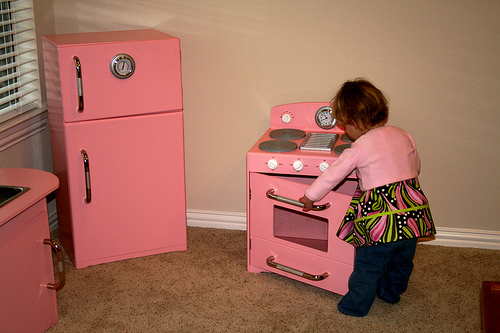

In [ ]:
im_path, caption = show_image_and_caption(7, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a woman is sitting in the grass


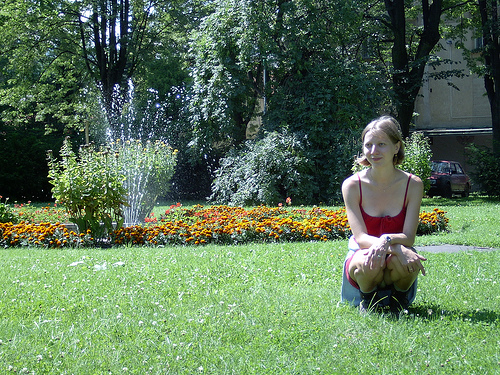

In [ ]:
im_path, caption = show_image_and_caption(340, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a man is playing a guitar on a street


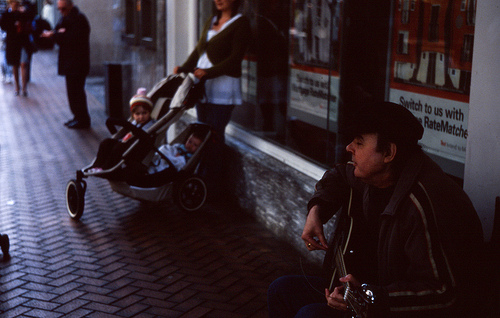

In [ ]:
im_path, caption = show_image_and_caption(611, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a man in a red shirt is running in the sand


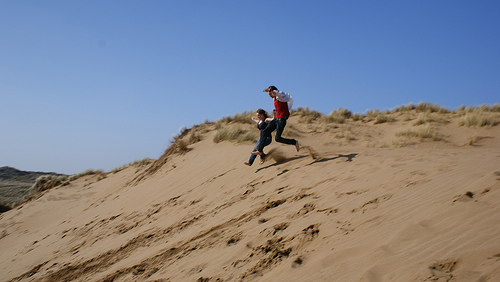

In [ ]:
im_path, caption = show_image_and_caption(542, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a group of children are playing in a park


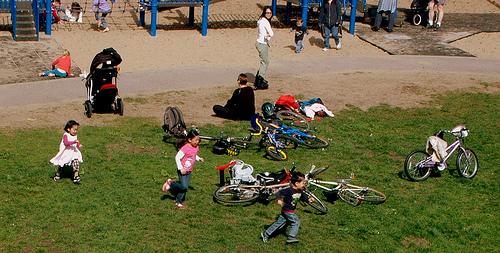

In [ ]:
im_path, caption = show_image_and_caption(417, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a man in a white shirt is cooking food in a kitchen


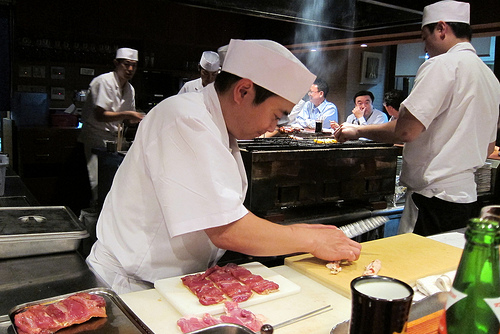

In [ ]:
im_path, caption = show_image_and_caption(581, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a woman in a black shirt is throwing a bowling ball


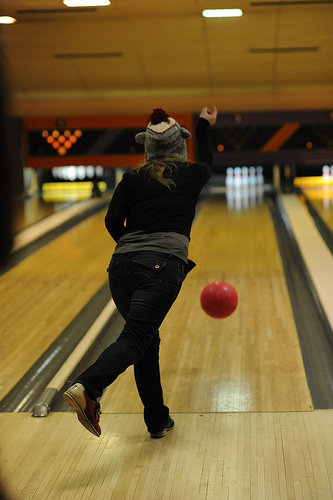

In [ ]:
im_path, caption = show_image_and_caption(110, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: two children are riding on a swing


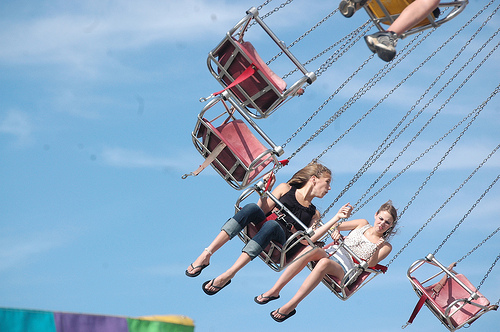

In [ ]:
im_path, caption = show_image_and_caption(133, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

### Κάποιες λιγότερο καλές Περιγραφές:

Caption: a group of people in red uniforms are standing in front of a crowd


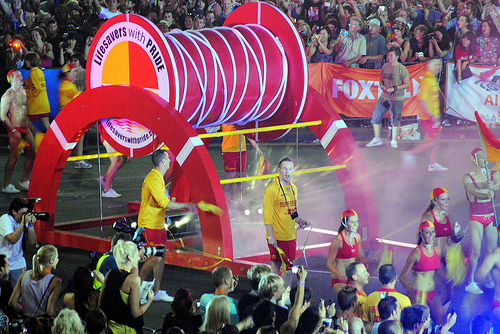

In [ ]:
im_path, caption = show_image_and_caption(982, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a man is sitting on a couch in a room


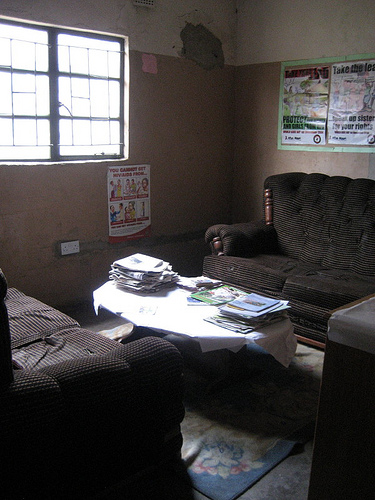

In [ ]:
im_path, caption = show_image_and_caption(718, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a group of people standing in front of a park


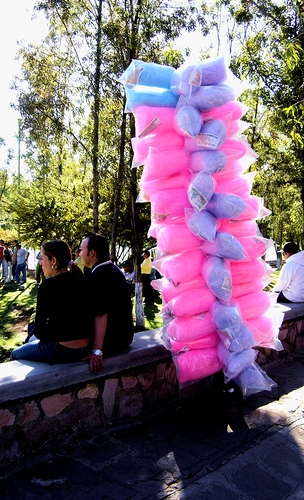

In [ ]:
im_path, caption = show_image_and_caption(277, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

Caption: a woman in a purple dress is playing a guitar


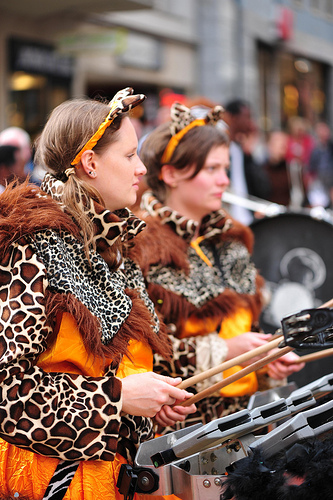

In [ ]:
im_path, caption = show_image_and_caption(875, gen_captions_pretrained)
print(f"Caption: {' '.join(caption)}")
Image.open(im_path)

## Διαγωνισμός στο Codalab
Είμαστε o user ececoffeeshop (ομάδα: team70) με και την στιγμή της παράδοσης είμαστε πρώτοι στο leaderboard 😀, όπως φαίνεται [εδώ](https://codalab.lisn.upsaclay.fr/competitions/926#participate-get_data)!!